In [1]:
import tensorflow as tf
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/hmltf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Data Loading and Transforming

features_path = "./training_set/features/"
labels_path = "./training_set/labels/"

test_features_path = "./test_set/features"
test_labels_path = "./test_set/labels"

def load_data(img_dir):
    all_imgs = []
    for img in sorted(os.listdir(img_dir)):
        if img.endswith(".jpeg"):
            image = cv2.imread(os.path.join(img_dir, img))
        
#             image = cv2.resize(image, (28, 28))
            all_imgs.append(image)
    return np.array(all_imgs)

def concat_frames(samples):
    num_samples = samples.shape[0]
    paired_samples = np.array(np.split(samples, num_samples / 2))
    
    concatenated_frames = []
    
    for pair in paired_samples:
        concatenated_frames.append(np.concatenate((pair[0], pair[1]), axis=2))

    return np.array(concatenated_frames)

def scale_pixel_values(samples):
    return samples / 255

def get_next_batch(num_samples, batch_size):
    # shuffle training set
    indices = np.random.randint(0, num_samples, batch_size)
    # take the red channel from RGB images
    return paired_frames[indices,:,:,:], label_imgs[indices,:,:,:]

In [3]:
# Training Data
feature_imgs = load_data(features_path) # (8470, 28, 28, 3)
label_imgs = load_data(labels_path) # (4235, 28, 28, 3)

# scale image values to [0, 1]
feature_imgs = scale_pixel_values(feature_imgs)
label_imgs = scale_pixel_values(label_imgs)

# stack feature images
paired_frames = concat_frames(feature_imgs) # (4235, 28, 28, 6)


# Test Data
test_feature_imgs = load_data(test_features_path)
test_label_imgs = load_data(test_labels_path)

test_feature_imgs = scale_pixel_values(test_feature_imgs)
test_label_imgs = scale_pixel_values(test_label_imgs)

test_paired_frames = concat_frames(test_feature_imgs)

In [4]:
label_imgs.shape

(4235, 28, 28, 3)

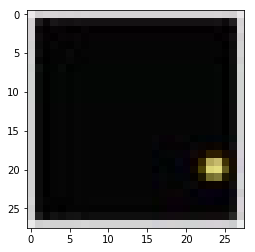

In [5]:
plt.imshow(feature_imgs[100])

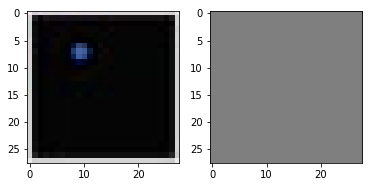

0 483.7867


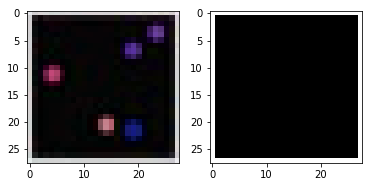

200 23.962704


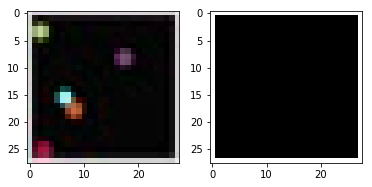

400 23.131308


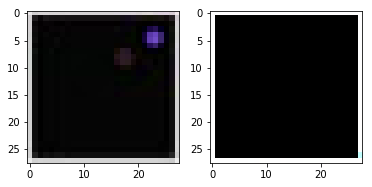

600 24.411959


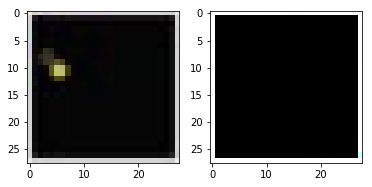

800 26.138226


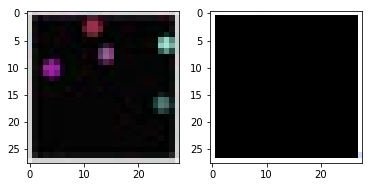

1000 24.421337


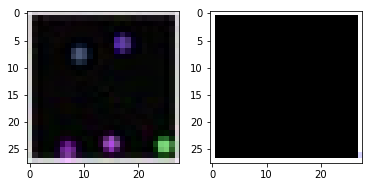

1200 24.312859


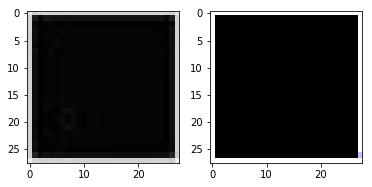

1400 24.183771


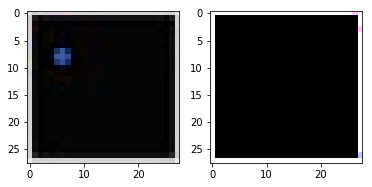

1600 24.090633


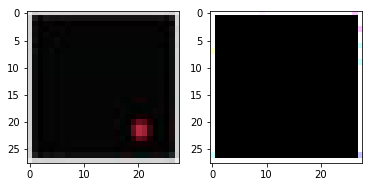

1800 24.258856


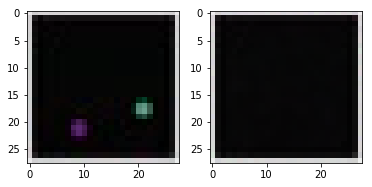

2000 12.233357


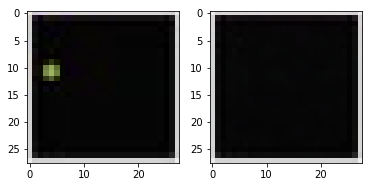

2200 10.580465


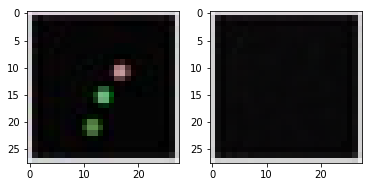

2400 11.885875


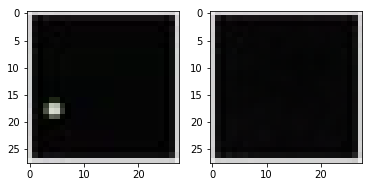

2600 11.122109


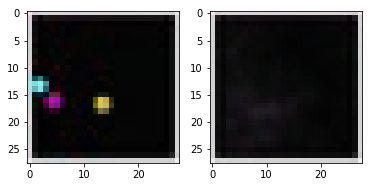

2800 10.44557


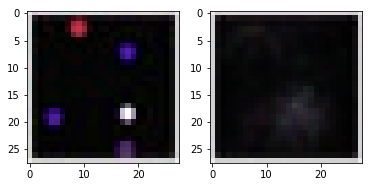

3000 10.487248


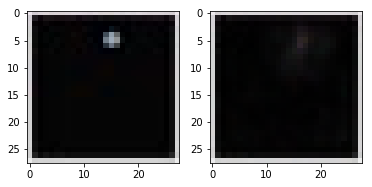

3200 9.3304405


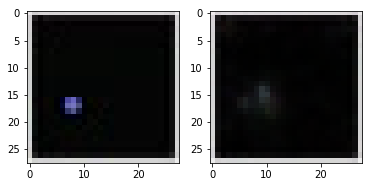

3400 8.1527405


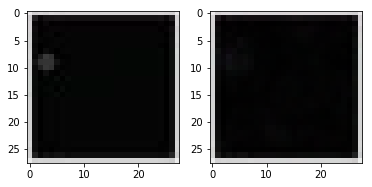

3600 8.344223


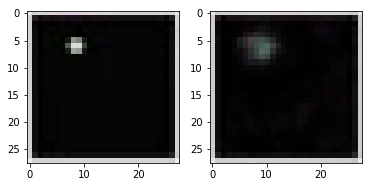

3800 8.932808


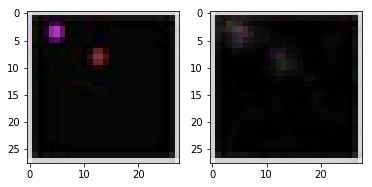

4000 6.4510036


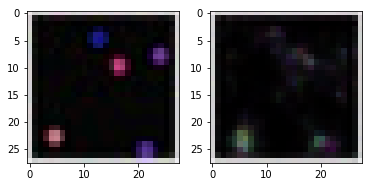

4200 5.6305685


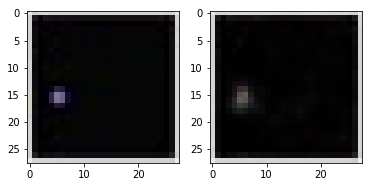

4400 6.968766


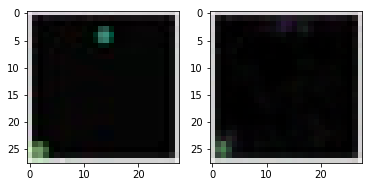

4600 5.8451576


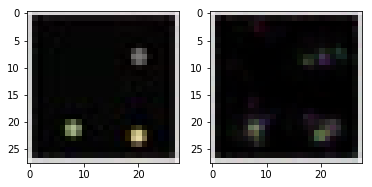

4800 5.3365436


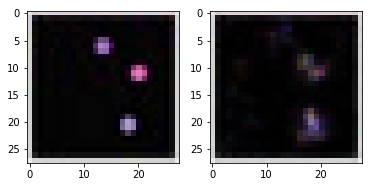

5000 4.7685833


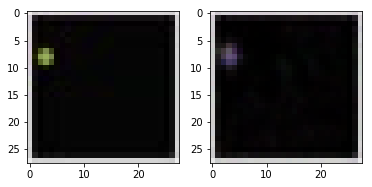

5200 4.0949945


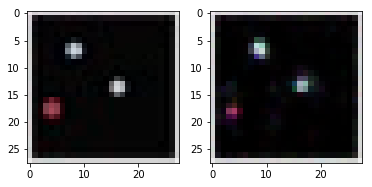

5400 3.677215


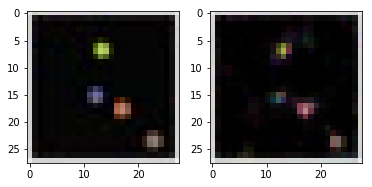

5600 3.4415703


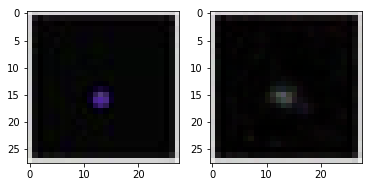

5800 2.8174388


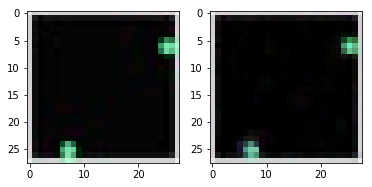

6000 2.4339871


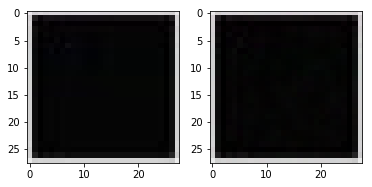

6200 2.5705829


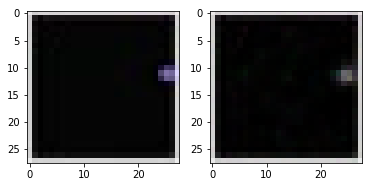

6400 2.1494424


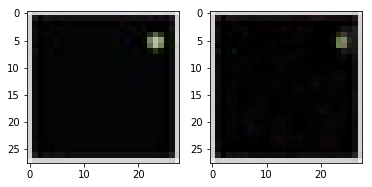

6600 1.7460346


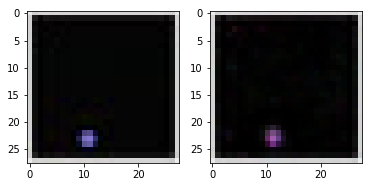

6800 1.8347707


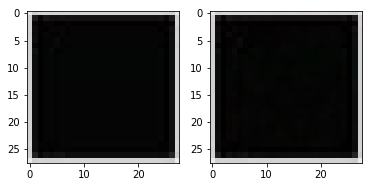

7000 1.6550157


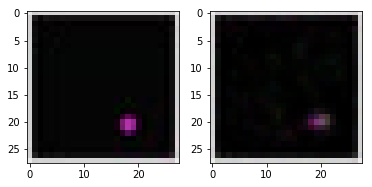

7200 1.4668635


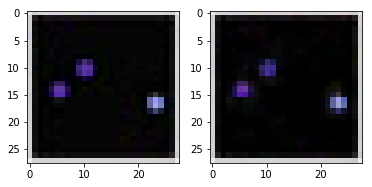

7400 1.3452213


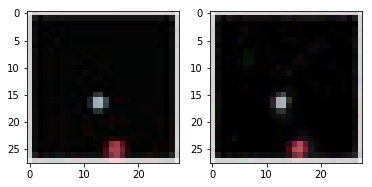

7600 1.3365782


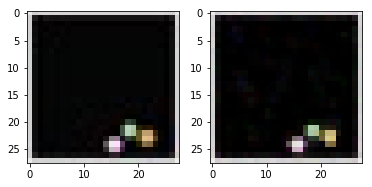

7800 1.137913


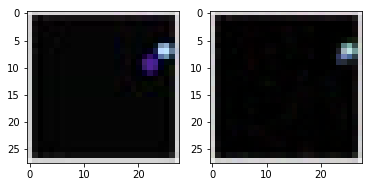

8000 1.1525135


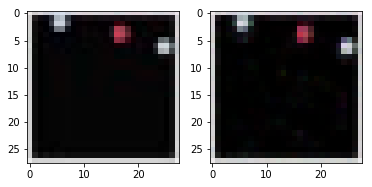

8200 1.1698405


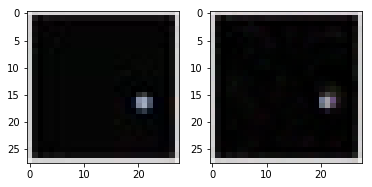

8400 1.019091


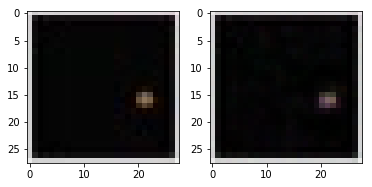

8600 0.9512383


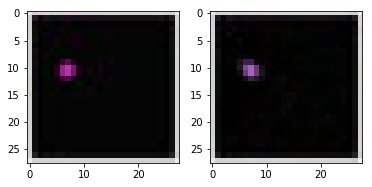

8800 1.0323226


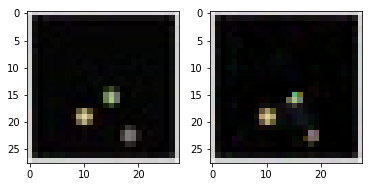

9000 0.8236281


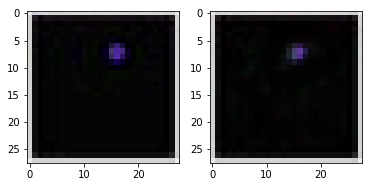

9200 0.84122556


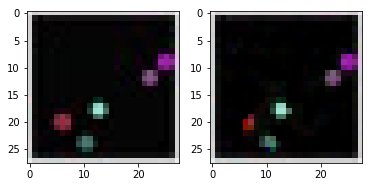

9400 0.9255758


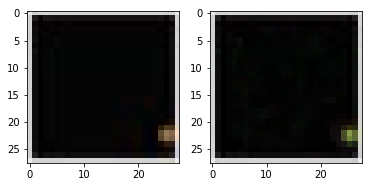

9600 0.8172997


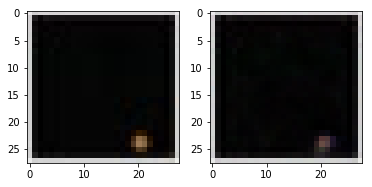

9800 0.7080004


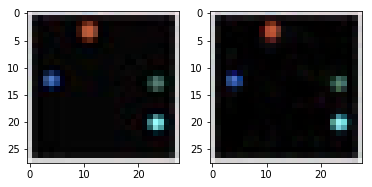

10000 0.72202647


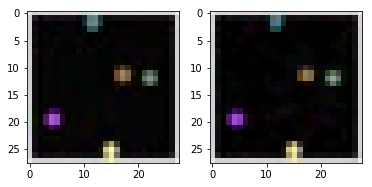

10200 0.722674


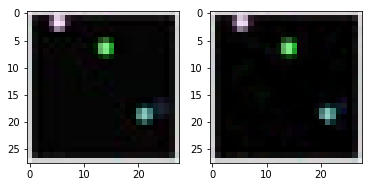

10400 0.6351868


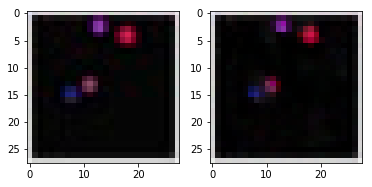

10600 0.67494416


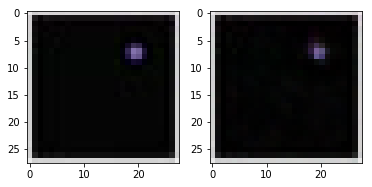

10800 0.64404786


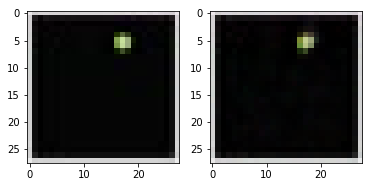

11000 0.6232951


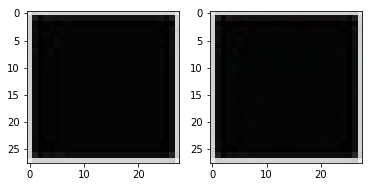

11200 0.61617136


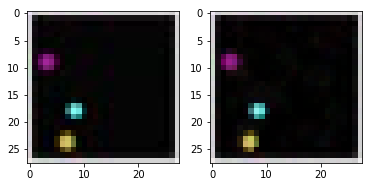

11400 0.6708676


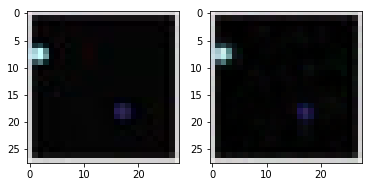

11600 0.5198603


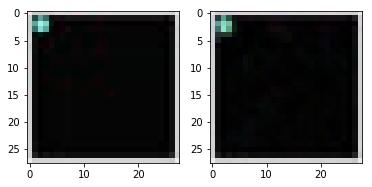

11800 0.5087334


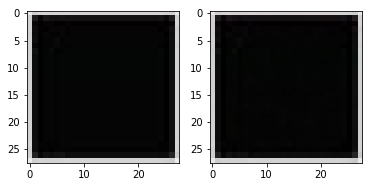

12000 0.51519954


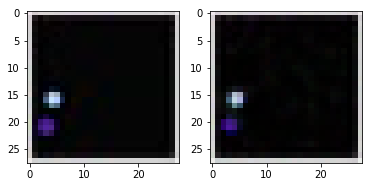

12200 0.48488247


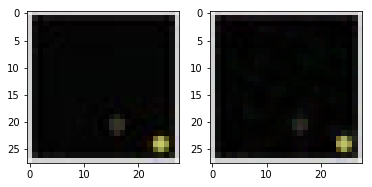

12400 0.51312166


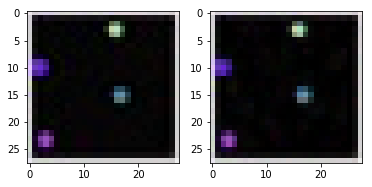

12600 0.5121275


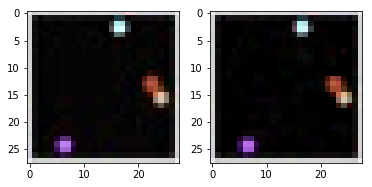

12800 0.46336615


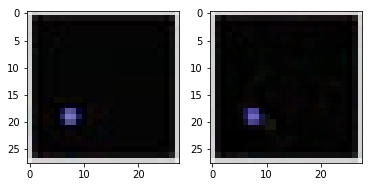

13000 0.47686163


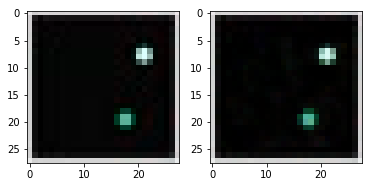

13200 0.45388407


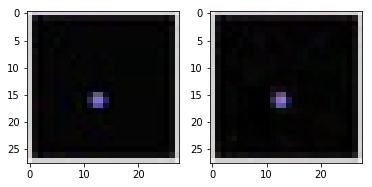

13400 0.39091218


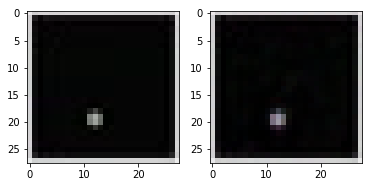

13600 0.46061414


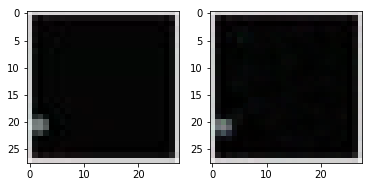

13800 0.37773758


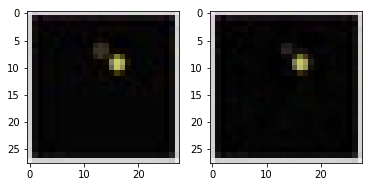

14000 0.42745593


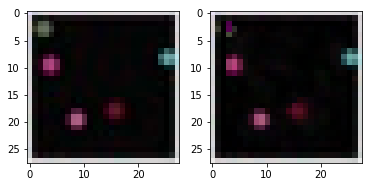

14200 0.4919653


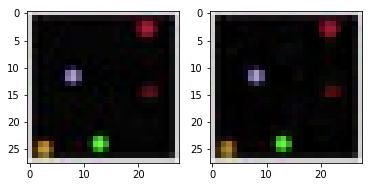

14400 0.4023049


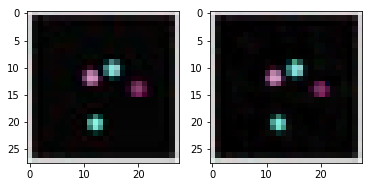

14600 0.33603907


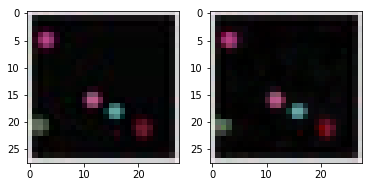

14800 0.37409133


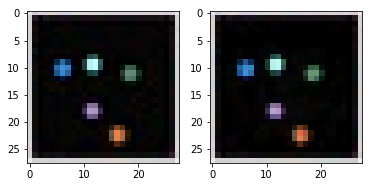

15000 0.40284652


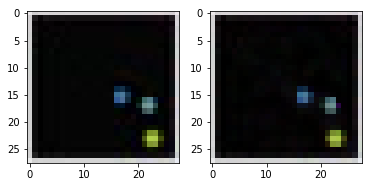

15200 0.39266407


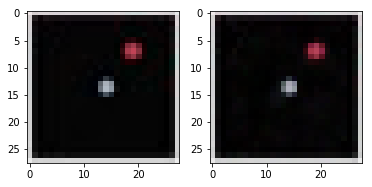

15400 0.41511512


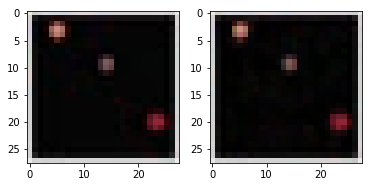

15600 0.33535063


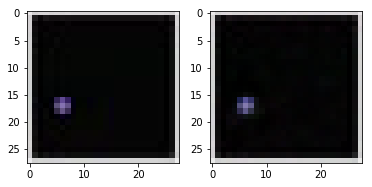

15800 0.3771133


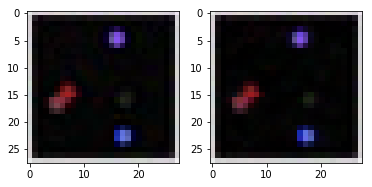

16000 0.3287152


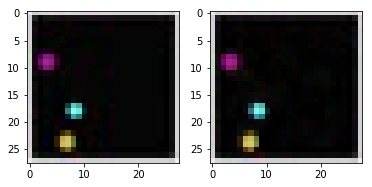

16200 0.34624898


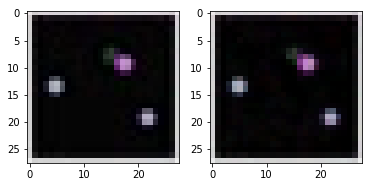

16400 0.3480336


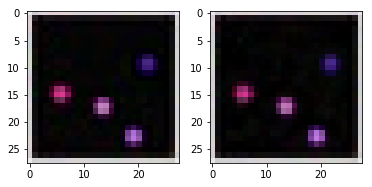

16600 0.30377385


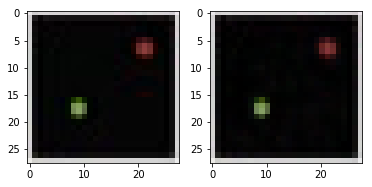

16800 0.31329617


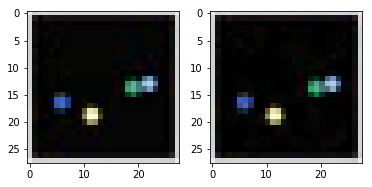

17000 0.33793354


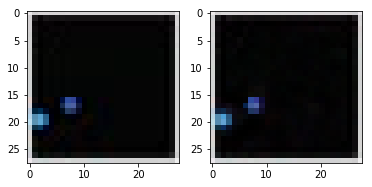

17200 0.2966106


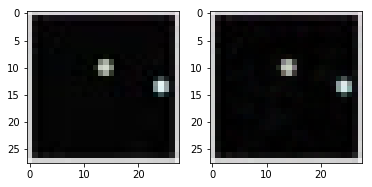

17400 0.33140397


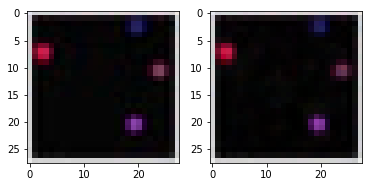

17600 0.30811045


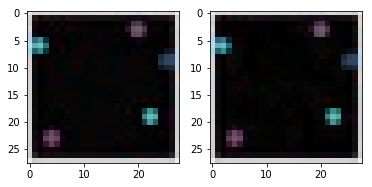

17800 0.32832968


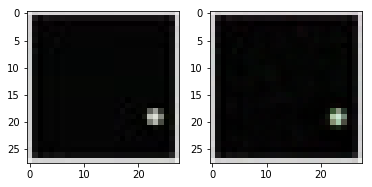

18000 0.3095622


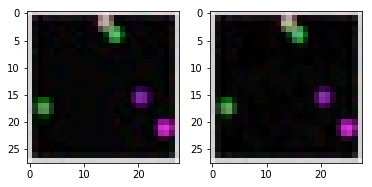

18200 0.3084219


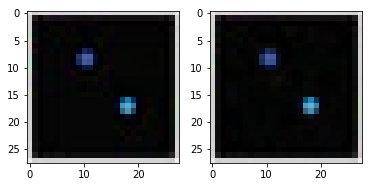

18400 0.31279683


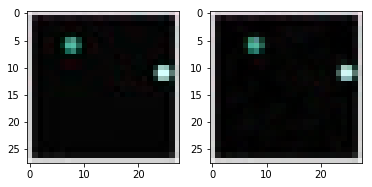

18600 0.28936404


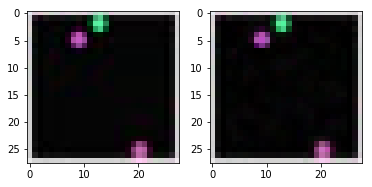

18800 0.28212756


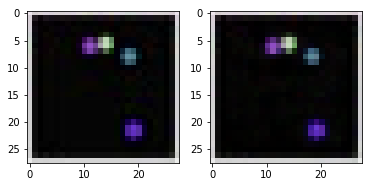

19000 0.2636813


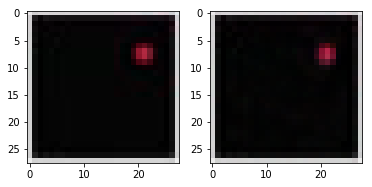

19200 0.2734697


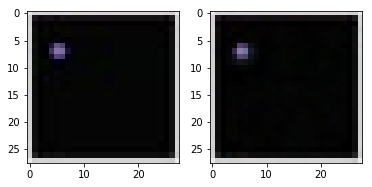

19400 0.2844782


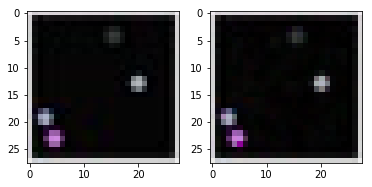

19600 0.294482


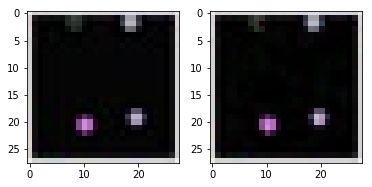

19800 0.2696949


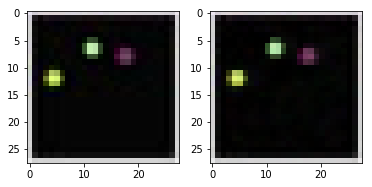

20000 0.25265992


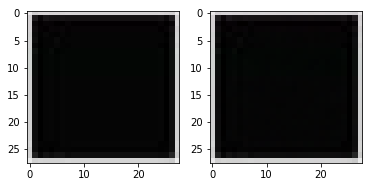

20200 0.28706098


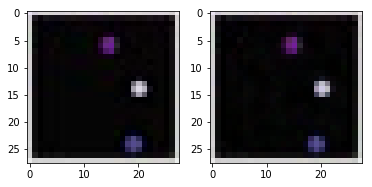

20400 0.2714616


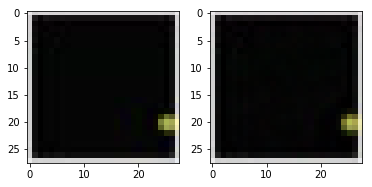

20600 0.25531286


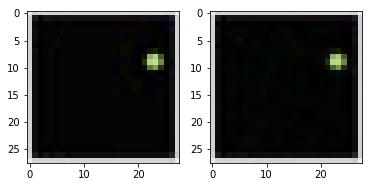

20800 0.23426402


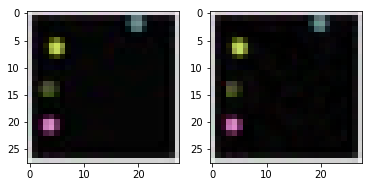

21000 0.27246374


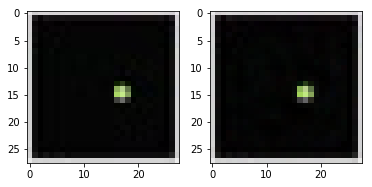

21200 0.26108143


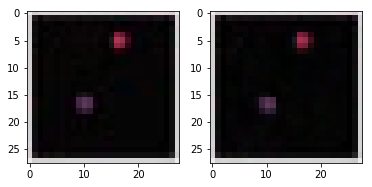

21400 0.23213762


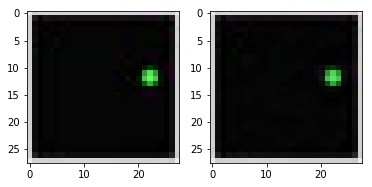

21600 0.25986144


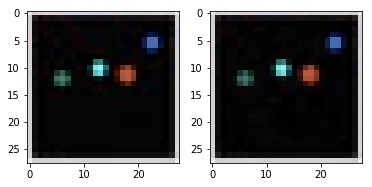

21800 0.2609004


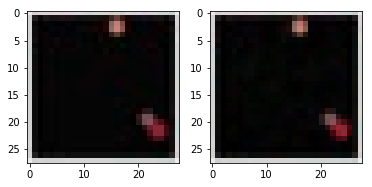

22000 0.23334366


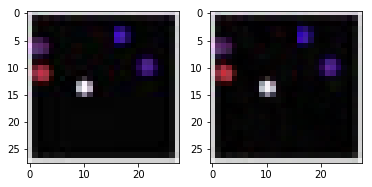

22200 0.24664488


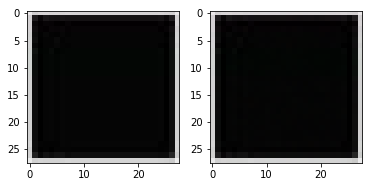

22400 0.2159158


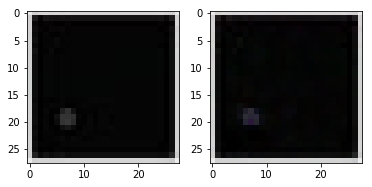

22600 0.2343032


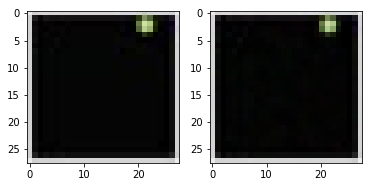

22800 0.2329092


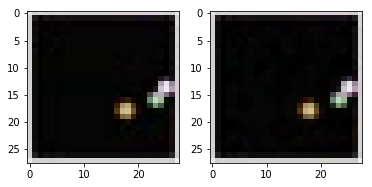

23000 0.2322165


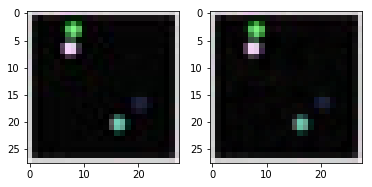

23200 0.20639148


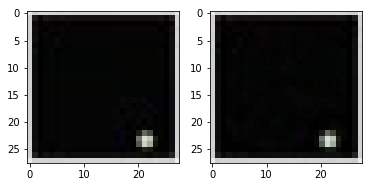

23400 0.24064071


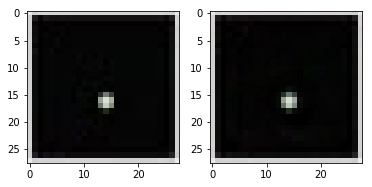

23600 0.23094875


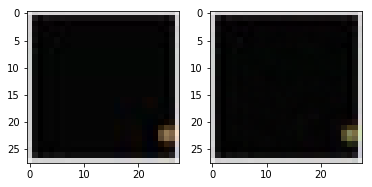

23800 0.23612823


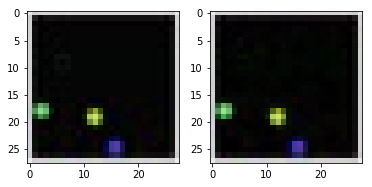

24000 0.21601382


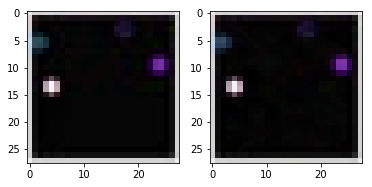

24200 0.20001316


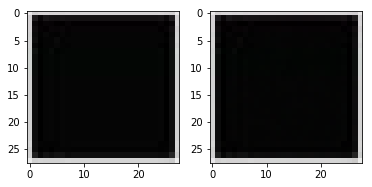

24400 0.20722945


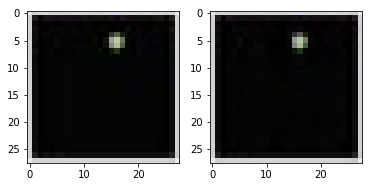

24600 0.218707


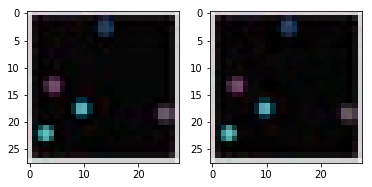

24800 0.21274069


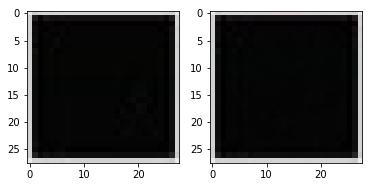

25000 0.19613913


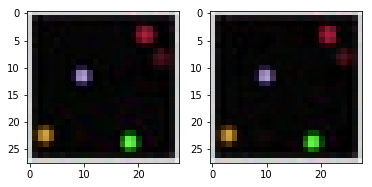

25200 0.20503664


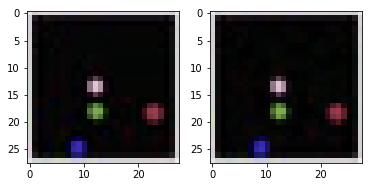

25400 0.19812486


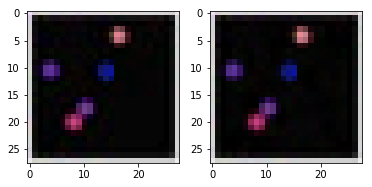

25600 0.19340008


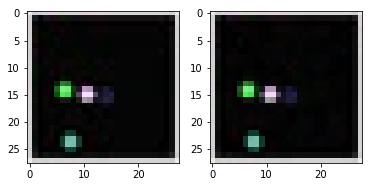

25800 0.17764051


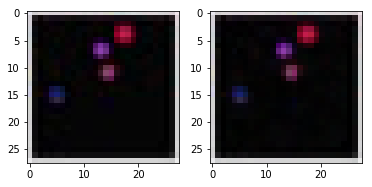

26000 0.1975292


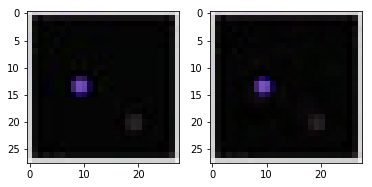

26200 0.19942382


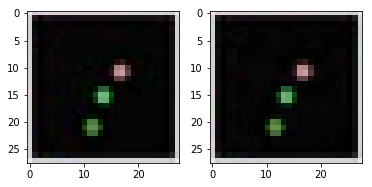

26400 0.1929296


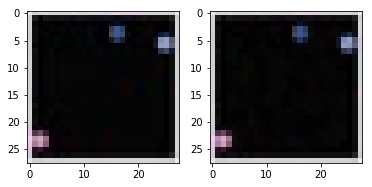

26600 0.18797696


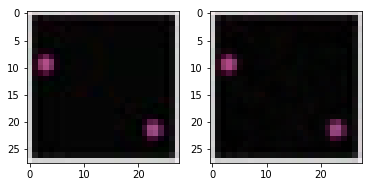

26800 0.17572634


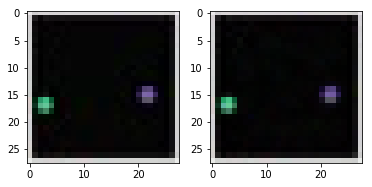

27000 0.17661007


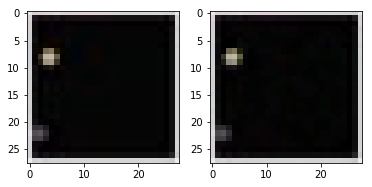

27200 0.16824223


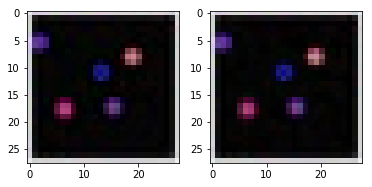

27400 0.21244523


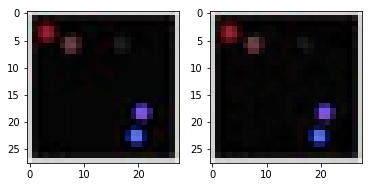

27600 0.18549508


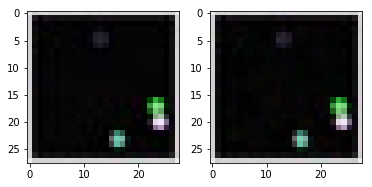

27800 0.19136143


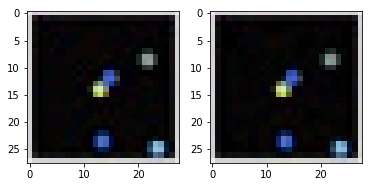

28000 0.1696908


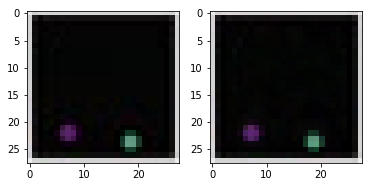

28200 0.18340838


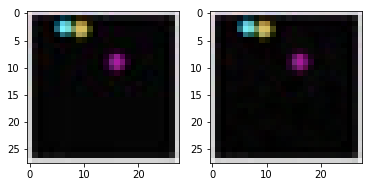

28400 0.18427148


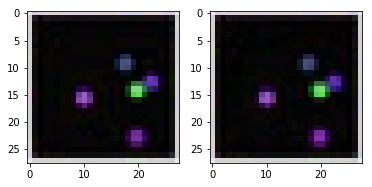

28600 0.18484303


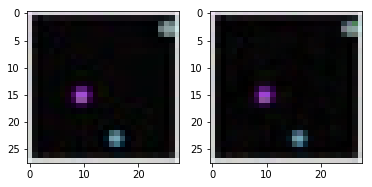

28800 0.17077017


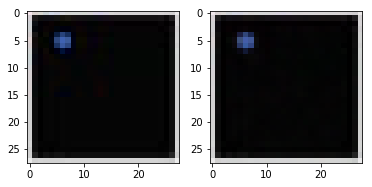

29000 0.17172307


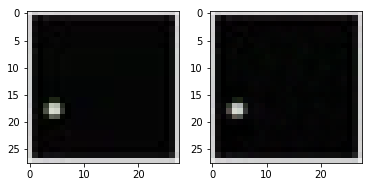

29200 0.17790926


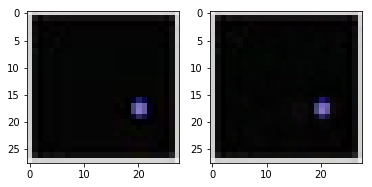

29400 0.17164218


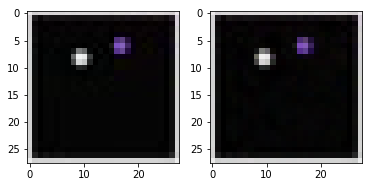

29600 0.18155709


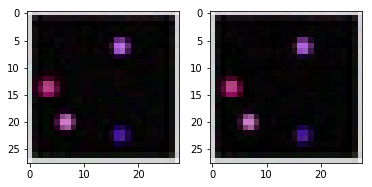

29800 0.16588093
Evaluation


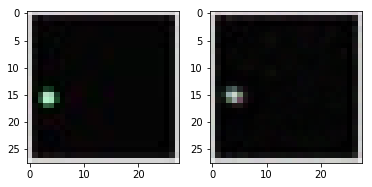

8.225408


In [6]:
# tensorflow model
tf.reset_default_graph()

batch_size = 64

X = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 6], name='X')
Y = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 3], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28 * 3])
keep_probability = tf.placeholder(dtype=tf.float32, shape=(), name='keep_probability')

def encoder(X, keep_probability):
    with tf.variable_scope("encoder", reuse=None):
        X_reshaped = tf.reshape(X, shape=[-1, 28, 28, 6])
        x = tf.layers.conv2d(X_reshaped, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
#         x = tf.nn.dropout(x, keep_probability)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
#         x = tf.nn.dropout(x, keep_probability)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
#         x = tf.nn.dropout(x, keep_probability)
        x = tf.contrib.layers.flatten(x)
        return tf.layers.dense(x, units=64)

    
def decoder(coding, keep_probability):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(coding, units=7*7*3, activation=tf.nn.relu)
        x = tf.reshape(x, [-1, 7, 7, 3])
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
#         x = tf.nn.dropout(x, keep_probability)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
#         x = tf.nn.dropout(x, keep_probability)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28*3, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28, 3])
        return img


encoding = encoder(X, keep_probability)
decoded = decoder(encoding, keep_probability)

decoded_flat = tf.reshape(decoded, [-1, 28*28*3])
img_loss = tf.reduce_sum(tf.squared_difference(decoded_flat, Y_flat), 1)
loss = tf.reduce_mean(img_loss)
training_op = tf.train.AdamOptimizer(0.0001).minimize(loss)
        
    
init = tf.global_variables_initializer()  

with tf.Session() as sess:
    init.run()
    for epoch in range(30000):
        x_batch, y_batch = get_next_batch(3640, batch_size)
        sess.run(training_op, feed_dict = {X: x_batch, Y: y_batch, keep_probability: 0.80})
               
        if not epoch % 200:
            ls, d = sess.run([loss, decoded], feed_dict = {X: x_batch, Y: y_batch, keep_probability: 1.0})             
            plt.subplot(1,2,1)
            plt.imshow(np.reshape(y_batch[0], [28, 28, 3]))
            plt.subplot(1,2,2)
            plt.imshow(d[0])
            plt.show()
            print(epoch, ls)  

    # Evaluation
    print("Evaluation")
    x_test = test_paired_frames
    y_test = test_label_imgs
    ls, d = sess.run([loss, decoded], feed_dict = {X: x_test, Y: y_test, keep_probability: 1.0})
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(y_test[0], [28, 28, 3]))
    plt.subplot(1,2,2)
    plt.imshow(d[0])
    plt.show()
    print(ls) 

In [7]:
# save target frames
import matplotlib.animation as animation
count = 0
for i, concatenated in enumerate(test_paired_frames[0:140, :, :, : ]):
    split = np.split(concatenated, 2, axis=2) 
    
    frame1 = split[0] * 255
    frame2 = split[1] * 255
    frame3 = test_label_imgs[i] * 255
   
    frame1_fname = "actual_" + str(count).zfill(3) + ".jpeg"
    frame2_fname = "actual_" + str(count + 1).zfill(3) + ".jpeg"
    frame3_fname = "actual_" + str(count + 2).zfill(3) + ".jpeg"
    
    path = "./vid_frames_actual/"
    cv2.imwrite(os.path.join(path, frame1_fname), frame1)
    cv2.imwrite(os.path.join(path, frame2_fname), frame2)
    cv2.imwrite(os.path.join(path, frame3_fname), frame3)
    
    count += 3

In [8]:
# save predicted frames
import matplotlib.animation as animation
count = 0
for i, concatenated in enumerate(test_paired_frames[0:140, :, :, : ]):
    split = np.split(concatenated, 2, axis=2) 
    
    frame1 = split[0] * 255
    frame2 = split[1] * 255
    frame3 = d[i] * 255
   
    frame1_fname = "predicted_" + str(count).zfill(3) + ".jpeg"
    frame2_fname = "predicted_" + str(count + 1).zfill(3) + ".jpeg"
    frame3_fname = "predicted_" + str(count + 2).zfill(3) + ".jpeg"
    
    path = "./vid_frames_predicted/"
    cv2.imwrite(os.path.join(path, frame1_fname), frame1)
    cv2.imwrite(os.path.join(path, frame2_fname), frame2)
    cv2.imwrite(os.path.join(path, frame3_fname), frame3)
    
    count += 3